In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class PCA(): 
    def __img_preprocess__(self,img):
        self.mean = np.mean(img)
        self.covar_mat = img-self.mean
        self.ei_val,self.ei_vec = np.linalg.eig(np.cov(self.covar_mat))
        # after calculating eigen vectors and eigen values, we will sort these vectors with respect to their eigen values 
        # this step will reduce sorting our eigen values each time we need to do a component analysis
        indx = np.argsort(self.ei_val)[::-1] # as we need this in decreasing order
        self.ei_vec = self.ei_vec[:,indx]
        self.ei_val = self.ei_val[indx]
    def __init__(self,img):
        self.__img_preprocess__(img)
    def reduce(self,components):
        variance = sum(self.ei_val[:components])/sum(self.ei_val)
        req_vec = self.ei_vec[:,:components] # selecting the required eigen vectors i.e., principle components
        score = np.dot(req_vec,np.dot(req_vec.T,self.covar_mat))+self.mean.T
        return np.uint8(np.absolute(score)),variance

Image reconstructed with 1 features:


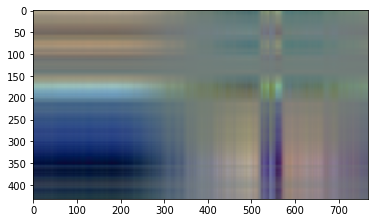

Image reconstructed with 10 features:


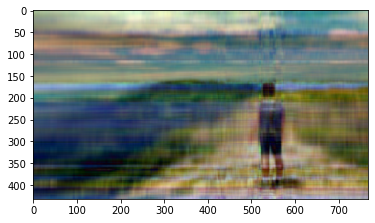

Image reconstructed with 50 features:


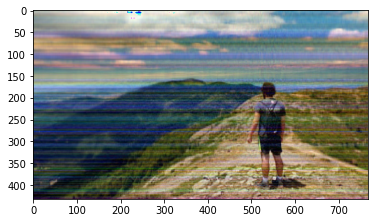

Image reconstructed with 100 features:


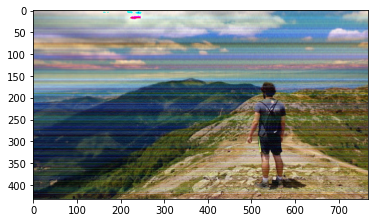

Image reconstructed with 250 features:


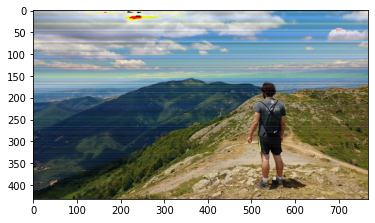

Image reconstructed with 400 features:


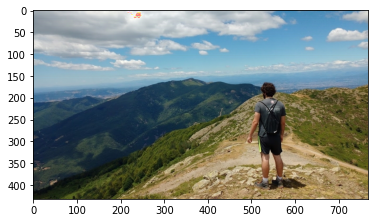

Image reconstructed with 500 features:


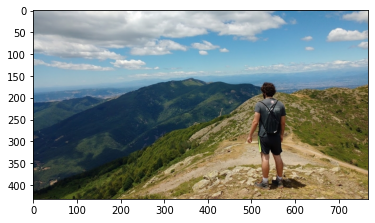

Image reconstructed with 700 features:


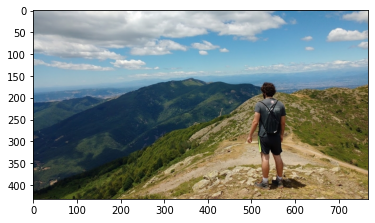

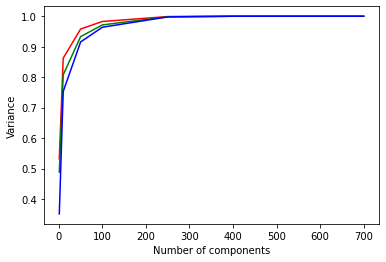

In [3]:
# performing PCA
img_path = r"C:\Users\Avinash\Desktop\Assingments\AML\hw3_1.jpeg"
img = np.asarray(Image.open(img_path))
red,green,blue = img[:,:,0],img[:,:,1],img[:,:,2]
PCA_red,PCA_green,PCA_blue = PCA(red),PCA(green),PCA(blue)
components = [1,10,50,100,250,400,500,700]
var = {'r':[],'g':[],'b':[]}
for c in components:
    red_t,red_var = PCA_red.reduce(c)
    green_t,green_var = PCA_green.reduce(c)
    blue_t,blue_var = PCA_blue.reduce(c)
    var['r'].append(red_var)
    var['g'].append(green_var)
    var['b'].append(blue_var)
    reconstructed = np.dstack((red_t,green_t,blue_t))
    print("Image reconstructed with {} features:".format(c))
    plt.imshow(Image.fromarray(reconstructed))
    plt.show()

plt.xlabel("Number of components")
plt.ylabel("Variance")
plt.plot(components,var['r'],color='red')
plt.plot(components,var['g'],color='green')
plt.plot(components,var['b'],color='blue')
plt.show()



In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
# !pip install --upgrade category_encoders
from category_encoders import OrdinalEncoder
from sklearn.metrics import accuracy_score

In [5]:
text_us=pd.read_csv(r"C:\Users\Avinash\Desktop\Assingments\AML\us.txt", header=None)
text_us.head()

,0
0,Timothy Moses
1,Anna Barajas
2,James Caldwell
3,Mr. Michael Cole
4,Jeffrey Collier


In [6]:
text_us.columns=["Name"]
text_us['Language']='USA'
text_us.head()

,Name,Language
0,Timothy Moses,USA
1,Anna Barajas,USA
2,James Caldwell,USA
3,Mr. Michael Cole,USA
4,Jeffrey Collier,USA


Importing the America dataset and adding Language as USA for that data set as a data in column of Language by creating it.

In [7]:
text_japan=pd.read_csv(r"C:\Users\Avinash\Desktop\Assingments\AML\japan.txt", header=None)
text_japan.head()

,0
0,鈴木 直子
1,中川 陽一
2,田中 香織
3,林 零
4,小林 千代


In [8]:
text_japan.columns=["Name"]
text_japan['Language']='Japanese'
text_japan.head()

,Name,Language
0,鈴木 直子,Japanese
1,中川 陽一,Japanese
2,田中 香織,Japanese
3,林 零,Japanese
4,小林 千代,Japanese


Importing the Japanese dataset and adding Language as Japanese for that data set as a data in column of Language by creating it.

In [9]:
text_arabic=pd.read_csv(r"C:\Users\Avinash\Desktop\Assingments\AML\arabic.txt", header=None)
text_arabic.head()

,0
0,رواء الموركة
1,نشوة الشامي
2,الدكتورة يسرى أفغاني
3,سنام الزرقان
4,المهندسة ليان القواسم


In [10]:
text_arabic.columns=["Name"]
text_arabic['Language']='Arabic'
text_arabic.head()

,Name,Language
0,رواء الموركة,Arabic
1,نشوة الشامي,Arabic
2,الدكتورة يسرى أفغاني,Arabic
3,سنام الزرقان,Arabic
4,المهندسة ليان القواسم,Arabic


Importing the Arabic dataset and adding Language as Arabic for that data set as a data in column of Language by creating it.

In [11]:
text_greek=pd.read_csv(r"C:\Users\Avinash\Desktop\Assingments\AML\greek.txt", header=None)
text_greek.head()

,0
0,Αρίσταρχος Καρανίκας
1,Βέρα Δώρη
2,Ρέα-Ναυσικά Λαλαούνη
3,Ιοκάστη-Ηράκλεια Γαλανάκη
4,Λήδα-Μελπομένη Φωτιάδου


In [12]:
text_greek.columns=["Name"]
text_greek['Language']='Greek'
text_greek.head()

,Name,Language
0,Αρίσταρχος Καρανίκας,Greek
1,Βέρα Δώρη,Greek
2,Ρέα-Ναυσικά Λαλαούνη,Greek
3,Ιοκάστη-Ηράκλεια Γαλανάκη,Greek
4,Λήδα-Μελπομένη Φωτιάδου,Greek


Importing the Greek dataset and adding Language as Greek for that data set as a data in column of Language by creating it.

In [13]:
text_total= pd.concat([text_us, text_arabic, text_greek, text_japan], axis=0, ignore_index=True)
print(text_total.shape)
text_total.head()

(4000, 2)


,Name,Language
0,Timothy Moses,USA
1,Anna Barajas,USA
2,James Caldwell,USA
3,Mr. Michael Cole,USA
4,Jeffrey Collier,USA


Concatenating the four(American, Japanese, Arabic and Greek data set in row wise by making Name and Language as name of the Columns in the final final dataset and making it ready to do preprocessing in the next steps

In [14]:
vectorize_transformation=CountVectorizer().fit(text_total['Name'])
text_transformed=vectorize_transformation.transform(text_total['Name']).toarray()
print(text_transformed)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Using CountVectorizer to transform the data in the Name column having different names in different languages and converting it into matrix based on the frequency of the words that occur in the Name column in 4 different languages so that the data can be used to train the Naice Bayes Machine Learning Model to classify the testing data set




In [15]:
language_mapping=[{'col': 'Language', 'mapping': {'USA':0, 'Japanese':1,'Arabic':2,'Greek':3}}]
encoder_language=OrdinalEncoder(mapping=language_mapping)
text_total=encoder_language.fit_transform(text_total)

Using OrdinalEncoder to map the Language name present in the Language column to integers from 0 to 3 so that they can be used to train the model




In [16]:
y=text_total['Language']
print(y)
x_train,x_test,y_train,y_test=train_test_split(text_transformed, y, test_size = 0.3, shuffle=True)

0       0
1       0
2       0
3       0
4       0
       ..
3995    1
3996    1
3997    1
3998    1
3999    1
Name: Language, Length: 4000, dtype: int32


Splitting the datset after preprocessing into testing and training datasets in 70 and 30 percentages respectively

In [17]:
samples_number,feature_number=x_train.shape
class_probability=np.zeros(4)
count,uniq_classes=np.unique(y_train,return_counts=True)
#print(uniq_classes)

In [18]:
i=0
while i<4:
  class_probability[i]=uniq_classes[i]/samples_number
  i+=1
print(class_probability)


[0.25714286 0.24321429 0.24857143 0.25107143]


Finding the probability of each data in Language column by Bayes multivariate  probability formula

In [19]:
class Naive_Bayes:     
    def model_train(self, x, y): 
        total_samples, num_of_feat = x_train.shape      #finding the total number of sampled and features
        diff_classes_1d = np.unique(y)                    #finding the uniques classes based on the req output
        num_of_cla = diff_classes_1d.shape[0]         #findinf the number of classses (4 here)
        #print(num_of_cla)
        lst=[]
        for i in range(num_of_feat):
            val = np.unique(x[:,i])              #appending the uniques values in the training data set present in the column of Name (matrix) based on thefeatures
            lst.append(val)
        #print(lst)
            
        self.total_y2d =np.zeros((num_of_cla, num_of_feat))
        self.total_y1d =np.zeros((num_of_cla))
        for i in diff_classes_1d:                                         #looping through number of classes 
            start_index =np.argwhere(y.to_numpy()==i).flatten()
            sum_of_col =[]
            for j in range(num_of_feat):
                sum_of_col.append(np.sum(x[start_index,j]))
            #print(sum_of_col)  
            self.total_y2d[i] =sum_of_col
            self.total_y1d[i] =np.sum(sum_of_col)
        #print(self.total_y2d)
        #print(self.total_y1d)
    
    def prospect(self, x, ind, alpha, num_of_feat):
        lst = []
        i=0
        while i <x.shape[0]:
            y2d =self.total_y2d[ind,i]            #finding the likelihood based on alpha value and likelihood formula
            y1d  =self.total_y1d[ind]
            formu=y2d+alpha
            fo1=alpha*num_of_feat
            val=(formu/(y1d + fo1))**x[i]
            lst.append(val)
            i+=1
        #print(lst)
        return np.prod(lst)
    
    def predict(self, x, alpha, num_of_cla, num_of_feat, class_P):        #predicting the classification values for the testing data set
        no_test_samples, no_t_feat = x.shape
        pred_prob = np.zeros((no_test_samples, num_of_cla))
        for i in range(no_test_samples):
            prospect_j = np.zeros((num_of_cla))
            for j in range(num_of_cla):
                prospect_j[j]  = class_P[j] * self.prospect(x[i], j, alpha, num_of_feat) 
            for j in range(num_of_cla):
                pred_prob[i,j] = (prospect_j[j]/np.sum(prospect_j))
        answer_index = np.argmax(pred_prob, axis=1)                                     #returning the values of max indices of the probabaility for each testing dataset
        return answer_index



Building the Multivariate Naive Bayes model and defining training, testing and likelihood calculation function by inputing class probability, alpha number of features e.t.c

In [20]:
ml_model = Naive_Bayes()
ml_model.model_train(x_train, y_train)
alpha = 8
ypred = ml_model.predict(x_test, alpha, 4, feature_number, class_probability)
print(ypred)
print('Accuracy is:', accuracy_score(ypred, y_test))

[0 2 3 ... 2 3 1]
Accuracy is: 0.9383333333333334


Training the NB model usinf training data set and predicting the result for the testing dataset and finding the accuracy of the result by comparing it with testing dataset

References


https://statisticsglobe.com/combine-pandas-dataframes-vertically-horizontally-python

https://stackoverflow.com/questions/41181779/merging-2-dataframes-vertically

https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/

https://machinelearningmastery.com/classification-as-conditional-probability-and-the-naive-bayes-algorithm/

https://leochoi146.medium.com/how-and-when-to-use-ordinal-encoder-d8b0ef90c28c

https://medium.com/@johnm.kovachi/implementing-a-multinomial-naive-bayes-classifier-from-scratch-with-python-e70de6a3b92e